**Module Path**

In [1]:
import os

os.chdir("./../../")

**Device**

In [2]:
from utils import get_device
from examples.pong.utils import preprocess, preprocess_batch

device = get_device()

# Policy Gradient Method


For estimating the gradient:

$$
\nabla_{\theta} J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta} (a_{t}^{(i)} | s_{t}^{(i)}) R^{(i)}
$$


---

## Explore Pong Deterministic

We begin by importing the necessary packages.

In [3]:
import numpy as np
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use("ggplot")
np.set_printoptions(precision=3, linewidth=120)

is_ipython = "inline" in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [4]:
from env import MultiFrameGym
from policy import RandomPolicy

Use the code cell below to create an instance of the Pong environment.

In [5]:
import torch

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
env = MultiFrameGym("pong")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Let's watch a random agent dealing with the environment

In [6]:
print(env.get_observation_space())
print(env.get_action_space())

Box(0, 255, (210, 160, 3), uint8)
Discrete(6)


In [7]:
env.env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

We will only use the actions `RIGHTFIRE` = 4 and `LEFTFIRE` = 5, the `FIRE` part ensures that the game starts again after losing a life

In [8]:
RIGHT = 4
LEFT = 5

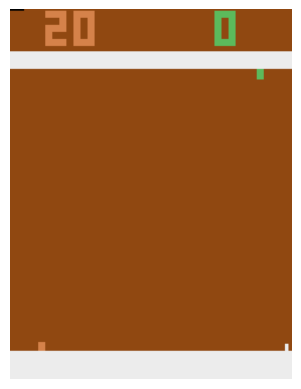

In [9]:
env.watch(
    RandomPolicy(env.get_action_space()),
    display,
    steps=1000,
    action1=RIGHT,
    action2=LEFT,
    preprocess_fn=preprocess_batch,
    device=device,
)

## Preprocessing

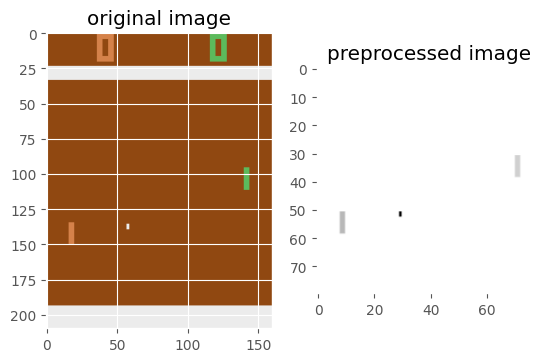

In [10]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
state = env.reset()[0]
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _, _ = env.step(1)

plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title("original image")

plt.subplot(1, 2, 2)
plt.title("preprocessed image")

# 80 x 80 black and white image
preprocessed_frame = preprocess(frame)
plt.imshow(preprocessed_frame, cmap="Greys")
plt.show()

In [11]:
frame.shape, preprocessed_frame.shape

((210, 160, 3), (80, 80))

In [12]:
env.reset()[0].shape

(210, 160, 3)

## Model

In [13]:
from model import FCBody, Conv2DBody
import torch.nn as nn

in_channels = 2
h_channels = 4
out_channels = 16
kernel_size = 6
h_stride = 2
a_stride = 4
h_activation = nn.ReLU()
a_activation = nn.ReLU()
h_bias = False
a_bias = True

state_size = out_channels * 9 * 9
hidden_size = 256
action_size = 1


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # input 80x80x2
        self.conv2dBody = Conv2DBody(
            in_channels=in_channels,
            h_channels=h_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            a_stride=a_stride,
            h_stride=h_stride,
            h_activation=h_activation,
            a_activation=a_activation,
            h_bias=h_bias,
            a_bias=a_bias,
        )
        # input 9x9x16
        self.fcBody = FCBody(
            s_size=state_size,
            a_size=action_size,
            h_size=hidden_size,
            h_activation=nn.ReLU(),
            a_activation=nn.Sigmoid(),
        )

    def forward(self, state):
        x = self.conv2dBody(state)
        x = self.fcBody(x)
        return x


model = Model().to(device)

## Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [14]:
from env import ParallelGym

parallelEnv = ParallelGym(name="pong", n_envs=4)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [15]:
from policy import ReinforceParallelPolicy

policy = ReinforceParallelPolicy(model, device)

## Train

In [16]:
import torch.optim as optim
from train import ReinforceParallelTrainer
from torch.optim.lr_scheduler import StepLR

max_steps_per_episode = 320
gamma = 0.99
print_every = 100
target_score = 10
n_episodes = 5_000
lr = 1e-4
lr_decay = 0.99


optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=50, gamma=lr_decay)

trainer = ReinforceParallelTrainer(
    policy=policy,
    environment=parallelEnv,
    optimizer=optimizer,
    scheduler=None,  # scheduler
    max_steps_per_episode=max_steps_per_episode,
    gamma=gamma,
    target_score=target_score,
    print_every=print_every,
    preprocess_state_fn=preprocess_batch,
    device=device,
)

In [17]:
beta = 0.01
beta_decay = 0.995

scores = trainer.train(
    n_episodes,
    action1=RIGHT,
    action2=LEFT,
    beta=beta,
    beta_decay=beta_decay,
    future_rewards_only=True,
    normalize_rewards=True,
)

Episode 100	Average Score: -13.58


Episode 200	Average Score: -12.91


Episode 300	Average Score: -12.69


Episode 400	Average Score: -11.72


Episode 500	Average Score: -11.01


Episode 600	Average Score: -10.03


Episode 700	Average Score: -8.66


Episode 800	Average Score: -7.81


Episode 900	Average Score: -7.10


Episode 1000	Average Score: -6.42


Episode 1100	Average Score: -5.80


Episode 1200	Average Score: -5.30


Episode 1300	Average Score: -4.94


Episode 1400	Average Score: -5.01


Episode 1500	Average Score: -4.58


Episode 1600	Average Score: -4.42


Episode 1700	Average Score: -4.06


Episode 1800	Average Score: -4.32


Episode 1900	Average Score: -3.85


Episode 2000	Average Score: -3.80


Episode 2100	Average Score: -3.81


Episode 2200	Average Score: -3.79


Episode 2300	Average Score: -3.72


Episode 2400	Average Score: -3.53


Episode 2500	Average Score: -3.45


Episode 2600	Average Score: -3.50


Episode 2700	Average Score: -3.57


Episode 2800	Average Score: -3.35


Episode 2900	Average Score: -3.40


Episode 3000	Average Score: -3.25


Episode 3100	Average Score: -3.33


Episode 3200	Average Score: -3.50


Episode 3300	Average Score: -3.34


Episode 3400	Average Score: -3.24


Episode 3500	Average Score: -3.29


Episode 3600	Average Score: -3.30


Episode 3700	Average Score: -3.50


Episode 3800	Average Score: -3.34


Episode 3900	Average Score: -3.30


Episode 4000	Average Score: -3.47


Episode 4100	Average Score: -3.37


Episode 4200	Average Score: -3.29


Episode 4300	Average Score: -3.33


Episode 4400	Average Score: -3.26


Episode 4500	Average Score: -3.08


Episode 4600	Average Score: -3.23


Episode 4700	Average Score: -3.08


Episode 4800	Average Score: -3.19


Episode 4900	Average Score: -3.10


Episode 5000	Average Score: -3.33


In [18]:
trainer.evaluate(5, action1=RIGHT, action2=LEFT)

Evaluation: Average reward over 5 episodes: -5.60


-5.6

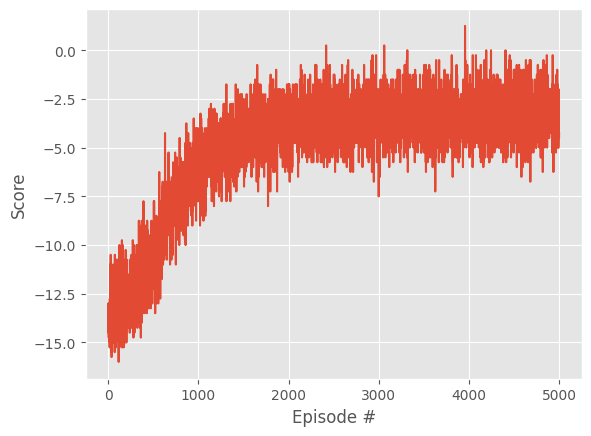

In [19]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel("Score")
plt.xlabel("Episode #")
plt.show()

## Save the agent

In [20]:
import torch

# Define the path where you want to save the model
model_path = "./checkpoints/reinforce_policy_cartpole.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

## Watch a Smart Agent

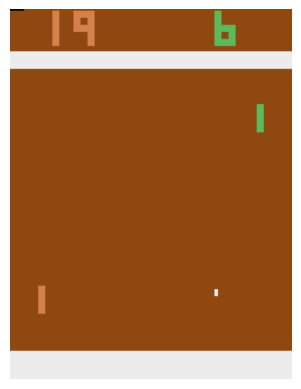

In [21]:
env.watch(
    policy,
    display,
    steps=1000,
    action1=RIGHT,
    action2=LEFT,
    preprocess_fn=preprocess_batch,
    device=device,
)